In [1]:
import arch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import warnings
import yfinance as yf
from datetime import date, datetime, timedelta
from operator import itemgetter
from sklearn.metrics import confusion_matrix
from typing import List, Tuple

from etl.load_volatility import get_data_with_vix
from indicators.transform import build_features
from indicators.temporal_features import difference_features


sns.set_style("darkgrid")

In [28]:
ticker = "SPY"
vix = "^VIX"
interval = "1d"
end_date = date.today()

# Covid.
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")
num_train_initial = 252*2

# No covid.
# start_date = datetime.strptime("2020-10-01", "%Y-%m-%d")
# num_train_initial = 126  # 6 months

regularise = False
use_fixed_train_size = False


df = get_data_with_vix(ticker, vix=vix, start_date=start_date, end_date=end_date, interval=interval)
features, target = build_features(
    df,
    features_cols=["price", "volume", "vix"],
    add_lag_features={"price": [1, 2, 3, 7], "vix": [1, 2, 3, 7]},
    add_yearly_features=True
)

print(f"df: {df.shape}, features: {features.shape}, target: {target.shape}")


price_predictions = []
for test_index in range(num_train_initial, len(df)):
    train_index = test_index - num_train_initial if use_fixed_train_size else 0

    # Train - IS Data.
    X_train = features.iloc[train_index:test_index]
    y_train = target.iloc[train_index:test_index]

    # Linear Regression vs. ElasticNet (GLMNet).
    model = sm.OLS(endog=y_train, exog=X_train)
    model = model.fit_regularized() if regularise else model.fit()

    # Test - OOS Data: note double [[]] to preserve batch_dim==1.
    X_test = features.iloc[[test_index]]
    y_test = target.iloc[[test_index]]

    price_next_pred = model.predict(X_test)
    price_predictions.append(price_next_pred)

    
# Align predictions.
pred_series = pd.concat(price_predictions, axis=0)
pred_series.name = "price_pred"
pred_df = pred_series.to_frame()
df = df.join(pred_df)

df.tail(2)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
df: (1523, 15), features: (1523, 14), target: (1523,)


,price,volume,vix,price_target,price-1,price-2,price-3,price-7,vix-1,vix-2,vix-3,vix-7,day_of_year,cos_day_of_year,sin_day_of_year,price_pred
Date,,,,,,,,,,,,,,,,
2023-01-30,400.589996,74202000,19.940001,406.480011,405.679993,404.750000,400.350006,388.640015,18.510000,18.73,19.08,20.52,30,0.870285,0.492548,400.287426
2023-01-31,406.480011,86811800,19.400000,410.799988,400.589996,405.679993,404.750000,395.880005,19.940001,18.51,18.73,19.85,31,0.861702,0.507415,405.864345


In [29]:
# Did the model predict the direction correctly?
df["dir_pred"] = (df["price_pred"] > df["price"]).astype(int)
df["dir_target"] = (df["price_target"] > df["price"]).astype(int)

cm = confusion_matrix(y_true=df["dir_target"], y_pred=df["dir_pred"], labels=[0, 1])
print(f"Confusion Matrix: {cm}")
print(f"TP + TN: {cm[0, 0] + cm[1, 1]}\nFP + FN: {cm[0, 1] + cm[1, 0]}")
print(f"Accuracy: {(cm[0, 0] + cm[1, 1])/np.sum(cm)}")

Confusion Matrix: [[433 254]
 [538 298]]
TP + TN: 731
FP + FN: 792
Accuracy: 0.4799737360472751


In [30]:
print("Final Model")
model_df = pd.DataFrame.from_dict({"params": model.params, "pvalues": model.pvalues})
reject_h0 = model_df.query("pvalues <= 0.05")
fail_reject_h0 = model_df.query("pvalues > 0.05")
print(model_df)
print("-"*20)
print(f"Reject H0:\n {reject_h0}")
print("-"*20)
print(f"Fail to reject H0:\n {fail_reject_h0}")

Final Model
                       params        pvalues
const            8.474722e-01   9.225067e-02
price            9.635558e-01  2.629307e-112
volume          -5.468295e-09   1.408590e-01
vix              2.111793e-01   6.002568e-03
price-1         -3.392895e-02   5.349141e-01
price-2         -5.480477e-02   3.159830e-01
price-3          8.752814e-02   3.773090e-02
price-7          3.466063e-02   8.770495e-02
vix-1           -4.106441e-01   2.480807e-05
vix-2           -6.896236e-02   4.809596e-01
vix-3            1.836149e-01   1.946265e-02
vix-7            1.224298e-01   2.637275e-03
cos_day_of_year  6.786063e-02   6.445611e-01
sin_day_of_year -1.147098e-01   4.360890e-01
--------------------
Reject H0:
            params        pvalues
price    0.963556  2.629307e-112
vix      0.211179   6.002568e-03
price-3  0.087528   3.773090e-02
vix-1   -0.410644   2.480807e-05
vix-3    0.183615   1.946265e-02
vix-7    0.122430   2.637275e-03
--------------------
Fail to reject H0:
         

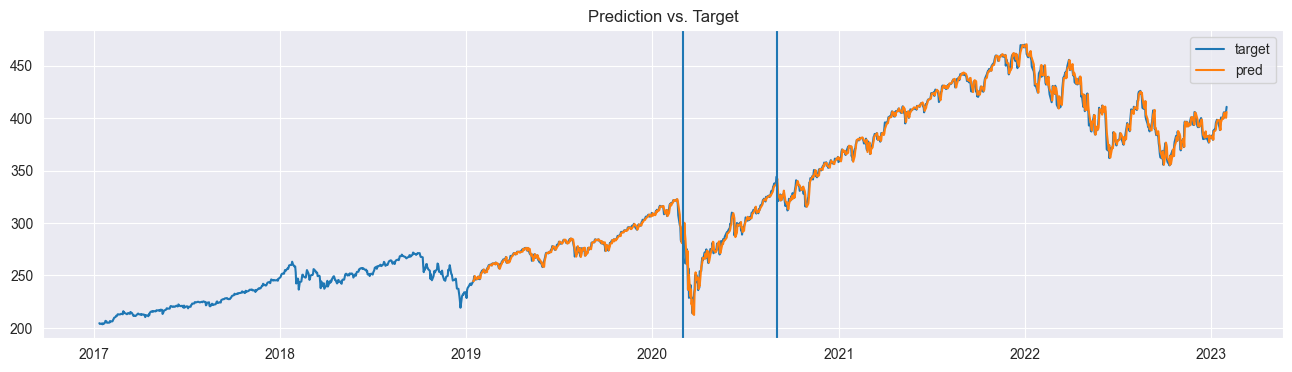

In [47]:
fig = plt.figure()
fig.set_size_inches(16, 4)

plt.plot(df["price_target"], label="target")
plt.plot(df["price_pred"], label="pred")

plt.axvline(datetime(2020, 3, 1))
plt.axvline(datetime(2020, 9, 1))
plt.title("Prediction vs. Target")
plt.legend()
plt.show()

In [38]:
df

,price,volume,vix,price_target,price-1,price-2,price-3,price-7,vix-1,vix-2,vix-3,vix-7,day_of_year,cos_day_of_year,sin_day_of_year,price_pred,dir_pred,dir_target
Date,,,,,,,,,,,,,,,,,,
2017-01-12,204.018311,72113200,11.540000,204.486679,204.531693,203.955307,203.955307,202.856522,11.260000,11.490000,11.560000,12.850000,12,0.978856,0.204552,NaN,0,1
2017-01-13,204.486679,62717900,11.230000,203.766129,204.018311,204.531693,203.955307,204.063385,11.540000,11.260000,11.490000,11.850000,13,0.975200,0.221325,NaN,0,0
2017-01-17,203.766129,61240800,11.870000,204.216461,204.486679,204.018311,204.531693,203.901276,11.230000,11.540000,11.260000,11.670000,17,0.957716,0.287717,NaN,0,1
2017-01-18,204.216461,54793300,12.480000,203.459946,203.766129,204.486679,204.018311,204.630753,11.870000,11.230000,11.540000,11.320000,18,0.952635,0.304115,NaN,0,0
2017-01-19,203.459946,66608800,12.780000,204.207443,204.216461,203.766129,204.486679,203.955307,12.480000,11.870000,11.230000,11.560000,19,0.947274,0.320423,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,400.350006,84800300,19.080000,404.750000,400.200012,400.630005,395.880005,398.500000,19.200001,19.809999,19.850000,18.350000,25,0.909308,0.416125,399.708940,0,1
2023-01-26,404.750000,72287400,18.730000,405.679993,400.350006,400.200012,400.630005,397.769989,19.080000,19.200001,19.809999,19.360001,26,0.902030,0.431673,404.604069,0,1
2023-01-27,405.679993,68280700,18.510000,400.589996,404.750000,400.350006,400.200012,391.489990,18.730000,19.080000,19.200001,20.340000,27,0.894487,0.447094,405.219222,0,0
